In [1]:
from IPython.display import display, HTML
import spot
from spot.jupyter import display_inline # display multiple arguments side-by-side
import buddy
spot.setup(show_default='.tvb')

# Anatomy of a product

In this notebook, we write a Python function that constructs the product of two automata.

This is obviously not a new feature: Spot can already make a product of two automata using its `product()` function.  
For instance:

In [2]:
a1 = spot.translate('FGa')
a2 = spot.translate('G(Fc U b)')
prod = spot.product(a1, a2)
display_inline(a1, a2, prod)

The builtin `spot.product()` function produces an automaton whose language is the intersection of the two input languages.  It does so by building an automaton that keeps track of the runs in the two input automata.  The states are labeled by pairs of input states so that we can more easily follow what is going on, but those labels are purely cosmetic.  The acceptance condition is the conjunction of the two acceptance condition, but the acceptance sets of one input automaton have been shifted to not conflict with the other automaton.

In fact, that automaton printer has an option to shift those sets in its output, and this is perfect for illustrating products.  For instance `a.show('+3')` will display `a1` with all its acceptance sets shifted by 3.  

Let's define a function for displaying the three automata involved in a product, using this shift option so we can follow what is going on with the acceptance sets.

In [3]:
def show_prod(a1, a2, res):
    s1 = a1.num_sets()
    display_inline(a1, a2.show('.tvb+{}'.format(s1)), res)

show_prod(a1, a2, prod)

# Building a product

Let's now rewrite `product()` in Python.  We will do that in three steps.


## First attempt

First, we build a product without taking care of the acceptance sets.  We just want to get the general shape of the algorithm.

We will build an automaton of type `twa_graph`, i.e., an automaton represented explicitely using a graph.  In those automata, states are numbered by integers, starting from `0`.  (Those states can also be given a different name, which is why the the `product()` shows us something that appears to be labeled by pairs, but the real identifier of each state is an integer.)

We will use a dictionary to keep track of the association between a pair `(ls,rs)` of input states, and its number in the output.

In [4]:
def product1(left, right):
    # A bdd_dict object associates BDD variables (that are 
    # used in BDDs labeleing the edges) to atomic propositions.
    bdict = left.get_dict()
    # If the two automata do not have the same BDD dict, then
    # we cannot easily detect compatible transitions.
    if right.get_dict() != bdict:
        raise RuntimeError("automata should share their dictionary")
        
    result = spot.make_twa_graph(bdict)
    # This will be our state dictionary
    sdict = {}
    # The list of output states for which we have not yet
    # computed the successors.  Items on this list are triplets
    # of the form (ls, rs, p) where ls,rs are the state number in
    # the left and right automata, and p is the state number if
    # the output automaton.
    todo = []
    # Transform a pair of state number (ls, rs) into a state number in
    # the output automaton, creating a new state if needed.  Whenever
    # a new state is created, we can add it to todo.
    def dst(ls, rs):
        pair = (ls, rs)
        p = sdict.get(pair)
        if p is None:
            p = result.new_state()
            sdict[pair] = p
            todo.append((ls, rs, p))
        return p
    
    # Setup the initial state.  It always exists.
    result.set_init_state(dst(left.get_init_state_number(), 
                              right.get_init_state_number()))

    # Build all states and edges in the product
    while todo:
        lsrc, rsrc, osrc = todo.pop()
        for lt in left.out(lsrc):
            for rt in right.out(rsrc):
                cond = lt.cond & rt.cond
                if cond != buddy.bddfalse:
                    result.new_edge(osrc, dst(lt.dst, rt.dst), cond)
    return result

p1 = product1(a1, a2)
show_prod(a1, a2, p1)

Besides the obvious lack of acceptance condition (which defaults to `t`) and acceptance sets, there is a less obvious problem: we never declared the set of atomic propositions used by the result automaton.  This as two consequences:
- calling `p1.ap()` will return an empty set of atomic propositions

In [5]:
print(a1.ap())
print(a2.ap())
print(p1.ap())

(a,)
(c, b)
()


- the `bdd_dict` instance that is shared by the three automata knows that the atomic propositions `a` and `b` are used by automata `a1` and that `b` and `c` are used by `a2`.  But it is unaware of `p1`.  That means that if we delete automata `a1` and `a2`, then the `bdd_dict` will release the associated BDD variables, and attempting to print automaton `p1` will either crash (because it uses bdd variables that are not associated to any atomic proposition) or display different atomic propositions (in case the BDD variables have been associated to different propositions in the meantime).

These two issues are fixed by either calling `p1.register_ap(...)` for each atomic proposition, or in our case `p1.copy_ap_of(...)` to copy the atomic propositions of each input automaton. 

## Second attempt: a working product

This fixes the list of atomtic propositions, as discussed above, and also sets the correct acceptance condition.
The `set_acceptance` method takes two arguments: a number of sets, and an acceptance function.  In our case, both of these arguments are readily computed from the number of states and acceptance functions of the input automata.

In [6]:
def product2(left, right):
    bdict = left.get_dict()
    if right.get_dict() != bdict:
        raise RuntimeError("automata should share their dictionary")
        
    result = spot.make_twa_graph(bdict)
    # Copy the atomic propositions of the two input automata
    result.copy_ap_of(left)
    result.copy_ap_of(right)
    
    sdict = {}
    todo = []
    def dst(ls, rs):
        pair = (ls, rs)
        p = sdict.get(pair)
        if p is None:
            p = result.new_state()
            sdict[pair] = p
            todo.append((ls, rs, p))
        return p
    
    result.set_init_state(dst(left.get_init_state_number(), 
                              right.get_init_state_number()))

    # The acceptance sets of the right automaton will be shifted by this amount
    shift = left.num_sets()
    result.set_acceptance(shift + right.num_sets(),
                          left.get_acceptance() & (right.get_acceptance() << shift))
    
    while todo:
        lsrc, rsrc, osrc = todo.pop()
        for lt in left.out(lsrc):
            for rt in right.out(rsrc):
                cond = lt.cond & rt.cond
                if cond != buddy.bddfalse:
                    # membership of this transitions to the new acceptance sets
                    acc = lt.acc | (rt.acc << shift)
                    result.new_edge(osrc, dst(lt.dst, rt.dst), cond, acc)
    return result

p2 = product2(a1, a2)
show_prod(a1, a2, p2)
print(p2.ap())

(a, c, b)


## Third attempt: a more usable product

We could stop with the previous function: the result is a correct product from a theoretical point of view.  However our function is still inferior to `spot.product()` in a couple of points:
- states are not presented as pairs
- the properties of the resulting automaton are not set

The former point could be addressed by calling `set_state_names()` and passing an array of strings: if a state number is smaller than the size of that array, then the string at that position will be displayed instead of the state number in the dot output.  However we can do even better by using `set_product_states()` and passing an array of pairs of states.  Besides the output routines, some algorithms actually retrieve this vector of pair of states to work on the product.

Regarding the latter point, consider for instance the deterministic nature of these automata.  In Spot an automaton is deterministic if it is both existential (no universal branching) and universal (no non-deterministic branching).  In our case we will restrict the algorithm to existantial input (by asserting `is_existential()` on both operands), so we can consider that the `prop_universal()` property is an indication of determinism:

In [7]:
print(a1.prop_universal())
print(a2.prop_universal())
print(prod.prop_universal())
print(p1.prop_universal())

maybe
yes
maybe
maybe


Because `a1` and `a2` are deterministic, their product is necessarily deterministic.  This is a property that the `spot.product()` algorithm will preserve, but that our version does not *yet* preserve.   We can fix that by adding

    if left.prop_universal() and right.prop_universal():
        result.prop_universal(True)
    
at the end of our function.  Note that this is **not** the same as

    result.prop_universal(left.prop_universal() and right.prop_universal())

because the results the `prop_*()` family of functions take and return instances of `spot.trival` values.  These `spot.trival`, can, as their name implies, take one amongst three values representing `yes`, `no`, and `maybe`.  `yes` and `no` should be used when we actually know that the automaton is deterministic or not (not deterministic meaning that there actually exists some non determinitic state in the automaton), and `maybe` when we do not know.  

The one-liner above is wrong for two reasons:

  - if `left` and `right` are non-deterministic, their product could be deterministic, so calling prop_universal(False) would be wrong. 

  - the use of the `and` operator on `trival` is misleading in non-Boolean context.   The `&` operator would be the correct operator to use if you want to work in threed-valued logic.  Compare: 

In [8]:
yes = spot.trival(True)
no = spot.trival(False)
maybe = spot.trival_maybe()
for u in (no, maybe, yes):
    for v in (no, maybe, yes):
        print("{u!s:>5} & {v!s:<5} = {r1!s:<5}     {u!s:>5} and {v!s:<5} = {r2!s:<5}"
              .format(u=u, v=v, r1=(u&v), r2=(u and v)))

   no & no    = no           no and no    = no   
   no & maybe = no           no and maybe = no   
   no & yes   = no           no and yes   = no   
maybe & no    = no        maybe and no    = maybe
maybe & maybe = maybe     maybe and maybe = maybe
maybe & yes   = maybe     maybe and yes   = maybe
  yes & no    = no          yes and no    = no   
  yes & maybe = maybe       yes and maybe = maybe
  yes & yes   = yes         yes and yes   = yes  


The reason `maybe and no` is equal to `maybe` is that Python evaluate it like `no if maybe else maybe`, but when a trival is evaluated in a Boolean context (as in `if maybe`) the result is True only if the trival is equal to yes.

So our

    if left.prop_universal() and right.prop_universal():
        result.prop_universal(True)

is OK because the `if` body will only be entered of both input automata are known to be deterministic.

However the question is in fact more general than just determinism: the product of two weak automata is weak, the product of two stutter-invariant automata is stutter-invariant, etc.  So when writing an algorithm one should consider which of the [property bits](https://spot.lrde.epita.fr/hoa.html#property-bits) are naturally preserved by the algorithm, and set the relevant bits: this can save time later if the resulting automaton is used as input for another algorithm.

In [9]:
def product3(left, right):
    # the twa_graph.is_existential() method returns a Boolean, not a spot.trival
    if not (left.is_existential() and right.is_existential()):
        raise RuntimeError("alternating automata are not supported")
    bdict = left.get_dict()
    if right.get_dict() != bdict:
        raise RuntimeError("automata should share their dictionary")
        
    result = spot.make_twa_graph(bdict)
    result.copy_ap_of(left)
    result.copy_ap_of(right)
    
    pairs = []   # our array of state pairs
    sdict = {}
    todo = []
    def dst(ls, rs):
        pair = (ls, rs)
        p = sdict.get(pair)
        if p is None:
            p = result.new_state()
            sdict[pair] = p
            todo.append((ls, rs, p))
            pairs.append((ls, rs)) # name each state
        return p
    
    result.set_init_state(dst(left.get_init_state_number(), 
                              right.get_init_state_number()))

    shift = left.num_sets()
    result.set_acceptance(shift + right.num_sets(),
                          left.get_acceptance() & (right.get_acceptance() << shift))
    
    while todo:
        lsrc, rsrc, osrc = todo.pop()
        for lt in left.out(lsrc):
            for rt in right.out(rsrc):
                cond = lt.cond & rt.cond
                if cond != buddy.bddfalse:
                    acc = lt.acc | (rt.acc << shift)
                    result.new_edge(osrc, dst(lt.dst, rt.dst), cond, acc)

    # Remember the origin of our states
    result.set_product_states(pairs)
    
    # Loop over all the properties we want to preserve if they hold in both automata
    for p in ('prop_universal', 'prop_complete', 'prop_weak', 'prop_inherently_weak', 
              'prop_terminal', 'prop_stutter_invariant', 'prop_state_acc'):
        if getattr(left, p)() and getattr(right, p)():
            getattr(result, p)(True)
    return result

p3 = product3(a1, a2)
show_prod(a1, a2, p3)
print(p3.prop_universal())

maybe


For development, it is useful to know that we can force the automaton printer to show the real state numbers (not the pairs) by passing option `1`, and that we can retrieve the associated pairs ourselves.  Note that the pairs also appear as tooltips when we mouse over the states.

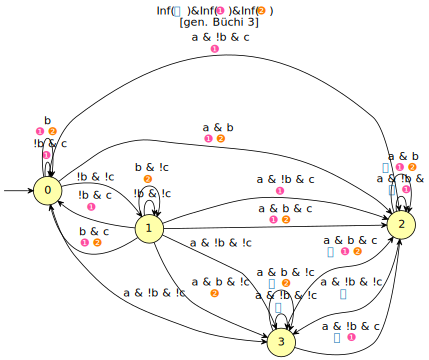

0: (0, 0)
1: (0, 1)
2: (1, 0)
3: (1, 1)


In [10]:
display(p3.show('.1'))
pairs = p3.get_product_states()
for s in range(p3.num_states()):
    print("{}: {}".format(s, pairs[s]))

# Timings

As an indication of how slow it is to implement such an algorithm using the Python bindings of Spot, consider the following comparison:

In [11]:
%timeit product3(a1, a2)

264 µs ± 2.11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
%timeit spot.product(a1, a2)

4.9 µs ± 45.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Depending on the machine where this notebook has been run, using the C++ version of the product can be 1 to 2 orders of magnitude faster.  This is due to all the type conversions (converting Python types to C++ types) that occurs everytime a function/method of Spot is called from Python.  When calling high-level C++ functions (such as `spot.product()`) from Python, the overhead is negligible because most of the time is spent on the C++ side, actually executing the function.  However when calling low-level functions (such as `new_edge()`, `new_state()`, `out()`) most of the time is spent converting the arguments from Python to C++ and the results from C++ to Python.

Despite that speed difference, Python can be useful to prototype an algorithm before implementing it in C++.

# The case of weak automata

Finally, note that `spot.product()` actually does a bit more: it has some specializations for when one of the argument of the product is marked as weak (as indicated by `prop_weak()`).  In this case, the resulting acceptance condition can be simplified a bit.